In [1]:
from qiskit import Aer, execute
from qiskit.quantum_info import Operator
from qiskit import QuantumCircuit
import numpy as np
import matplotlib as mpl
from qiskit.visualization import plot_histogram
import random

In [2]:
# Early initialization for compiling, don't change
max_bits = -1
max_qubits = -1


# Below are all the functions used by the algorithm
# Run everything until the end, where you'll find the implementation!

In [3]:
# hash algorithm in classical. Flips all even bits in the password to create hash, and adds 2 salt (random) bits at end (input must be int)
def hash_algorithmClassic(passwordInt):
    
    # gets password into 
    passwordBits = format(passwordInt, "0"+str(max_bits)+"b")       # Gives password in binary with length of max_bits
    
    print("Password int: ", passwordInt)
    print("Password bits: ", passwordBits)
    
    # divides string into array to perform iteration
    arrayBits = [int(d) for d in str(passwordBits)]
    
    # iterate over array of bit values and swaps all bits in even position
    for i in range(len(arrayBits)):
        if i%2 == 0:
            arrayBits[i] = int(arrayBits[i])^(1)    # BIT FLIP OPERATOR
    
    
    # joins array
    hashBits = ''.join(str(e) for e in arrayBits)


    # creates random bits and adds them to end of hashBits, depending on difference between max_bits and max_qubits
    saltBits = format(random.getrandbits(max_qubits-max_bits), "02b")
    hashBits = hashBits + saltBits
    
    print("Hash int: ", int(hashBits,2))
    print("Hash bits: ", hashBits)

In [4]:
# Algorithm will flip every qubit in an odd position (instead of even, done in the classical hash algorithm), starting at 1. E.g: 1000 will become 1101
def hash_algorithmQuantum(n):
    
    # create a quantum circuit on n qubits
    qc = QuantumCircuit(n)
    
    # apply algorithm
    for i in range(n):
        if i%2 == 1:
            qc.x(i)
    
    return qc

In [5]:
# ADAPTED FROM PUBLIC ALGORITHM
def phase_oracle(n, indices_to_mark, name = 'Oracle'):
    
    # create a quantum circuit on n qubits
    qc = QuantumCircuit(n, name=name)
    
    # apply the hash function to all values   # PERSONAL WORK
    qc.append(hash_algorithmQuantum(n), range(n))
    # qc.x(range(n))
    
    # create the identity matrix on n qubits
    oracle_matrix = np.identity(2**n)
    # add the -1 phase to marked elements
    for index_to_mark in indices_to_mark:
        oracle_matrix[index_to_mark, index_to_mark] = -1

        
    # convert your matrix (called oracle_matrix) into an operator, and add it to the quantum circuit
    qc.unitary(Operator(oracle_matrix), range(n))
    
    return qc

In [6]:
# PUBLIC ALGORITHM
def diffuser(n):
    
    # create a quantum circuit on n qubits
    qc = QuantumCircuit(n, name='Diffuser')
    
    # apply hadamard gates to all qubits
    qc.h(range(n))
    # call the phase oracle applied to the zero state
    qc.append(phase_oracle(n, [0]), range(n))
    # apply hadamard gates to all qubits
    qc.h(range(n))
    
    return qc

In [7]:
# ADAPTED PUBLIC ALGORITHM  
# Grover's algorithm. Input must be the hash of the password in bits
def Grover(n, indices_of_marked_elements):

    # Makes sure hash is within boundaries
    if(indices_of_marked_elements[0]>2**n):
        print("ERROR: Hash is too large for the number of bits")
        return
    
    # Create a quantum circuit on n qubits
    qc = QuantumCircuit(n, n)
    
    # Determine
    r = int(np.floor(np.pi/4*np.sqrt(2**n/len(indices_of_marked_elements))))
    print(f'{n} qubits, basis states {indices_of_marked_elements} marked, {r} rounds')
    
    # step 1: apply Hadamard gates on all qubits
    qc.h(range(n))
    
    # step 2: apply r rounds of the phase oracle and the diffuser
    for _ in range(r):
        qc.append(phase_oracle(n, indices_of_marked_elements), range(n))
        qc.append(diffuser(n), range(n))
        
    # step 3: measure all qubits
    qc.measure(range(n), range(n))
  
    return qc


In [8]:
# Sets up and runs the simulator to get counts, which is to be displayed as a histogram
def simulateCountsCircuit(circuit):

    simulator = Aer.get_backend('qasm_simulator')
    counts = execute(circuit, backend=simulator, shots=500).result().get_counts(circuit)

    # Removes counts that have less than 5 items (are reduntant and make a messy / hard to read graph)
    counts = {k:v for k, v in counts.items() if v > 5}
    print(counts)

    # Swaps key values from binary to integer
    # Iteration inspiration from https://stackoverflow.com/questions/45877614/how-to-change-all-the-dictionary-keys-in-a-for-loop-with-d-items 
    kv = list(counts.items())
    counts.clear()

    for k, v in kv:
        new_key = int(k,2)  # Swaps key from binary to int
        counts[new_key] = v

    return counts

In [9]:
# Decodes counts by: finding the hash in counts, and fixing the password format (the hash and password should be the most common counts)
def decodeCounts(counts, inputHash):
    
    # Gets the max values of counts, which are the hash and password
    maxValue = sorted(counts, key=lambda k: counts[k], reverse=True)[0]
    secondMaxValue = sorted(counts, key=lambda k: counts[k], reverse=True)[1]

    
    print("Max value: ", maxValue)
    print("Second max value: ", secondMaxValue)
    print("Hash: ", inputHash)

    password = -1

    # If the highest value is the hash, then the second highest value is the password
    if(maxValue == inputHash):   
        print("Grover's algorithm found hash!")
        password = secondMaxValue

    elif(secondMaxValue == inputHash):
        print("Grover's algorithm found hash!")
        password = maxValue

    else:
        print("Grover's algorithm did not work...")
        return


    passwordBit = format(password, "0"+str(max_qubits)+"b")      # Gives password in binary with length of max_bits
    passwordBitFixed = passwordBit[0:max_qubits-(max_qubits-max_bits)]    # Removes the salt bits at the end
    passwordFixed = int(passwordBitFixed,2)  # Converts the binary to int

    print("GROVER'S ALGORITHM FOUND THIS PASSWORD: ", passwordFixed)


In [10]:
# TIME TO RUN EVERYTHING! 
# First, define how long you want the password to be (max_bits), and use the function to hash a password
# For max number of bits, highest possible password int is be 2^n, where n is max_bits. 
# E.g: 8 bits, password can be any integer from 0 to 256

# GLOBAL VARIABLES
max_bits = 8                    # Max number of bits in password
amount_of_salt_bits = 2         # Amount of bits to add to hash for salting
max_qubits = max_bits + amount_of_salt_bits       # WARNING, MORE THAN 10 QUBITS IS VERY SLOW!!! RECOMMENDED TO KEEP AT OR BELOW 10.

# Use this to hash a password! Password must be int!
hash_algorithmClassic(100)      # This algorithm only prints to clearly separate classical algorithm and quantum algorithm. Put the hash in variable below!

Password int:  100
Password bits:  01100100
Hash int:  824
Hash bits:  1100111000


10 qubits, basis states [824] marked, 25 rounds
{'0110010010': 113, '1100111000': 111}
{402: 113, 824: 111}
Max value:  402
Second max value:  824
Hash:  824
Grover's algorithm found hash!
GROVER'S ALGORITHM FOUND THIS PASSWORD:  100


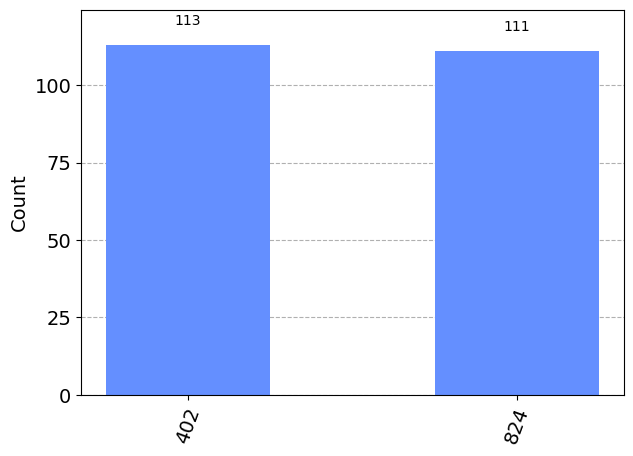

In [12]:
# This takes around a minute to run. Define the variables as you please and watch the magic occur!
hash = 824                # The hash we want to unhash (INTEGER)

# Implementation
groverCircuit = Grover(max_qubits, [hash])      # This creates the Quantum Circuit corresponding to Grover's algorithm, including the Oracle with the hash
counts = simulateCountsCircuit(groverCircuit)   # This simulates the circuit and gets the counts
print(counts)
decodeCounts(counts, hash)   # This decodes the counts to find the password and hash
plot_histogram(counts)      # This gives a solution that is almost correct. It finds the hash, and it finds the password with 2 extra salt bits at the end


In [ ]:
# Ruben Aguilo Schuurs
# 22nd October 2023
# University of Wisconsin Madison
# LinkedIn: https://www.linkedin.com/in/ru-s